# Análisis de la etapa de generación de medios

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import plotly.express as px

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU. Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [21]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [22]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "gasdev": ["ran2"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}
overall_time= {}
overall_memory = {}

In [23]:
def get_data(file_name):
    data = []
    row = {}

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            split_line = line.split()
                
            if "USED" not in split_line and "ELAPSED" not in split_line and "CPU" not in split_line: continue
    
            if "CPU" in split_line:
                idx_cpu = split_line.index("CPU") + 1
                idx_per = idx_cpu + 1
                row["cpu"] = row.get('CPU', [])
                row["cpu"].append(float(split_line[idx_per].rsplit("%")[0]))
                continue
                
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
                        
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            if "cpu" in row:
                row["cpu"] = sum(row["cpu"]) / len(row["cpu"])
            data.append(row)
            row = {}
            
    return data

In [24]:
def create_df(file_name):
    data = get_data(file_name)
    df = pd.DataFrame(data)
    return df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median'], 'cpu': ['min', 'max', 'mean']})

In [25]:
def analyze(file_name):
    df_grouped = create_df(file_name)
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [26]:
def merge_dfs(dfs):
    functions = ['Py_kgeneration', 'generate', 'fftma2', 'covariance', 'gasdev', 'fourt', 'cov_value', 'ran2', 'build_real', 'prebuild_gwn', 'clean_real', 'cgrid', 'length', 'maxfactor']
    df_final = pd.concat(dfs, join='inner').sort_values(by=('time', 'sum'), ascending=False) 

    memory_min, memory_max, memory_median = [], [], []
    time_min, time_max, time_mean, time_sum, time_count = [], [], [], [], []
    cpu_min, cpu_max, cpu_mean = [], [], []

    for function in functions:
        memory_min.append(df_final.loc[function, ('memory', 'min')].min())
        time_min.append(df_final.loc[function, ('time', 'min')].min())
        cpu_min.append(df_final.loc[function, ('cpu', 'min')].min())
        memory_max.append(df_final.loc[function, ('memory', 'max')].max())
        time_max.append(df_final.loc[function, ('time', 'max')].max())
        cpu_max.append(df_final.loc[function, ('cpu', 'max')].max())
        time_mean.append(df_final.loc[function, ('time', 'mean')].mean())
        cpu_mean.append(df_final.loc[function, ('cpu', 'mean')].mean())
        time_sum.append(df_final.loc[function, ('time', 'sum')].sum())
        time_count.append(df_final.loc[function, ('time', 'count')].sum())
        try:
            memory_median.append(df_final.loc[function, ('memory', 'median')].median())
        except:
            memory_median.append(df_final.loc[function, ('memory', 'median')])
        
    df = pd.DataFrame({('memory', 'min'): memory_min, ('memory', 'max'): memory_max, ('memory', 'median'): memory_median, ('time', 'min'): time_min, ('time', 'max'): time_max, ('time', 'mean'): time_mean, ('time', 'sum'): time_sum, ('time', 'count'): time_count, ('cpu', 'min'): cpu_min, ('cpu', 'max'): cpu_max, ('cpu', 'mean'): cpu_mean})

    df.index = functions
    df.index.name = 'function'
    return df

In [27]:
def analyze(file_names):
    if len(file_names) == 1:
        df_grouped = create_df(file_names[0])
        return df_grouped.sort_values(by=('time', 'sum'), ascending=False)
    else:
        dfs = []
        for file_name in file_names:
            print("Executing file {}".format(file_name))
            df = create_df(file_name)
            dfs.append(df)
        return merge_dfs(dfs)

In [28]:
def plot_pie(df, function, plt, column):
    
    labels = relations[function][:]
    total = abs(df.loc[function][column])
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = abs(df.loc[func][column])
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    
    if rest > 0:
        labels.append("other")
        sizes.append(rest/total)
        explode.append(0 if rest/total > 0.01 else 0.1)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    

    if not np.isnan(sizes).all():
    
        plt.set_title(function)

        patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
        labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

        sort_legend = True
        if sort_legend:
            patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                                  key=lambda x: x[2],
                                                  reverse=True))

        plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
                   fontsize=8)

        plt.axis('equal')

def plot_pie_charts(df, title, column):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(title)
    functions = list(relations.keys())
    for i in range(2):
        for j in range(2):
            plot_pie(df,functions[2*i + j], axs[i, j], column)
    

In [29]:
parents = {
    "Py_kgeneration": "",
    "generate": "Py_kgeneration",
    "gasdev": "generate",
    "fftma2":  "Py_kgeneration",
    "covariance": "fftma2",
    "fourt": "fftma2",
    "prebuild_gwn": "fftma2",
    "ran2": "gasdev",
    "cov_value": "covariance",
}

def plot_treemap(df, column, name):
    df["parent"] = [parents.get(item, "") for item in df.index]
    df2 = df.reset_index()
    df2[name] = df2[[column]]
    df2 = df2[["function", "parent", name]]
    fig3 = px.treemap(df2, names='function', parents='parent',values=name, color="parent", title="Time treemap")
    fig3.show()

## N = 8

### Armado del dataset

In [30]:
df = analyze(['log_8-aa'])
overall_time["8"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["8"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

memory                     cpu                          \
                  min  max median         min         max        mean   
function                                                                
Py_kgeneration    1.2  1.2    1.2   75.100000   75.100000   75.100000   
generate          1.3  1.3    1.3  100.100000  100.100000  100.100000   
gasdev           -0.2  0.2    0.0    0.000000  100.100000    5.669727   
fftma2           -0.1 -0.1   -0.1   30.534783   30.534783   30.534783   
covariance       -0.1 -0.1   -0.1   31.918182   31.918182   31.918182   
cov_value        -0.2  0.2    0.0    0.000000  100.100000    0.859143   
ran2             -0.2  0.2    0.0    0.000000  100.100000    0.998148   
fourt             0.0  0.0    0.0    0.000000    0.000000    0.000000   
cgrid             0.0  0.0    0.0    0.000000    0.000000    0.000000   
length            0.0  0.0    0.0    0.000000    0.000000    0.000000   
clean_real        0.0  0.0    0.0    0.000000    0.000000    0.000000   
prebuild_gwn      0.0  0.0    0.0    0.000000    0.000000    0.000000   
build_real        0.0  0.0    0.0    0.000000    0.000000    0.000000   
maxfactor         0.0  0.0    0.0    0.000000    0.000000    0.000000   

                    time                                      
                     min       max      mean       sum count  
function                                                      
Py_kgeneration  0.633546  0.633546  0.633546  0.633546     1  
generate        0.397899  0.397899  0.397899  0.397899     1  
gasdev          0.000106  0.007636  0.000579  0.296354   512  
fftma2          0.234361  0.234361  0.234361  0.234361     1  
covariance      0.224350  0.224350  0.224350  0.224350     1  
cov_value       0.000103  0.000966  0.000134  0.093502   700  
ran2            0.000101  0.000583  0.000133  0.093435   702  
fourt           0.000553  0.000795  0.000664  0.001993     3  
cgrid           0.001623  0.001623  0.001623  0.001623     1  
length          0.000355  0.000359  0.000358  0.001073     3  
clean_real      0.000463  0.000463  0.000463  0.000463     1  
prebuild_gwn    0.000454  0.000454  0.000454  0.000454     1  
build_real      0.000410  0.000410  0.000410  0.000410     1  
maxfactor       0.000105  0.000106  0.000105  0.000316     3

### Comparación de tiempos

Una vez reconocidas qué funciones llaman a otras, se muestra en los siguientes gráficos cuánto tiempo consume cada función respecto del total que insume la función invocante.

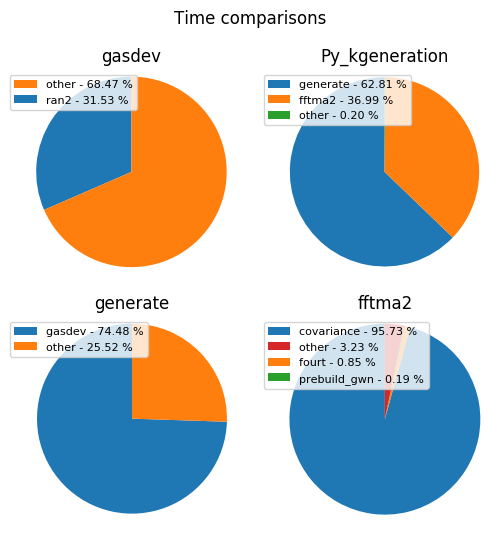

In [31]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [33]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

Una vez reconocidas qué funciones llaman a otras, se muestra en los siguientes gráficos cuánta memoria consume cada función respecto del total que insume la función invocante.

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



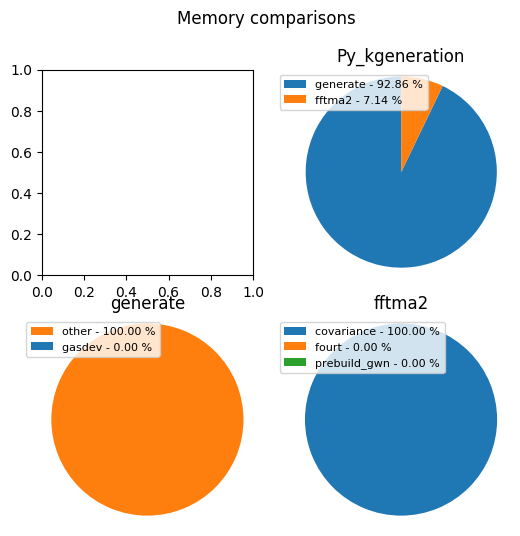

In [32]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## N = 16

### Armado del dataset

In [34]:
df = analyze(['log_16-aa'])
overall_time["16"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["16"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

memory                     cpu                         \
                  min   max median        min         max       mean   
function                                                               
Py_kgeneration  -21.2 -21.2  -21.2  37.944037   37.944037  37.944037   
generate        -20.0 -20.0  -20.0  41.633546   41.633546  41.633546   
gasdev          -23.9   3.0    0.0   0.000000  100.100000   2.239697   
fftma2           -1.2  -1.2   -1.2  28.555285   28.555285  28.555285   
covariance       -1.2  -1.2   -1.2  28.555285   28.555285  28.555285   
ran2             -9.1   1.3    0.0   0.000000  100.100000   0.456891   
cov_value        -3.8   0.9    0.0   0.000000  100.100000   0.365993   
fourt             0.0   0.0    0.0   0.000000    0.000000   0.000000   
cgrid             0.0   0.0    0.0   0.000000    0.000000   0.000000   
length            0.0   0.0    0.0   0.000000    0.000000   0.000000   
maxfactor         0.0   0.0    0.0   0.000000    0.000000   0.000000   
build_real        0.0   0.0    0.0   0.000000    0.000000   0.000000   
prebuild_gwn      0.0   0.0    0.0   0.000000    0.000000   0.000000   
clean_real        0.0   0.0    0.0   0.000000    0.000000   0.000000   

                    time                                      
                     min       max      mean       sum count  
function                                                      
Py_kgeneration  4.518677  4.518677  4.518677  4.518677     1  
generate        3.283041  3.283041  3.283041  3.283041     1  
gasdev          0.000099  0.121965  0.000595  2.437584  4096  
fftma2          1.231253  1.231253  1.231253  1.231253     1  
covariance      1.223604  1.223604  1.223604  1.223604     1  
ran2            0.000095  0.001958  0.000135  0.710129  5268  
cov_value       0.000101  0.001366  0.000137  0.488994  3564  
fourt           0.000824  0.001123  0.000944  0.002831     3  
cgrid           0.001635  0.001635  0.001635  0.001635     1  
length          0.000352  0.000360  0.000356  0.001069     3  
maxfactor       0.000103  0.000112  0.000106  0.000318     3  
build_real      0.000274  0.000274  0.000274  0.000274     1  
prebuild_gwn    0.000267  0.000267  0.000267  0.000267     1  
clean_real      0.000217  0.000217  0.000217  0.000217     1

### Comparación de tiempos

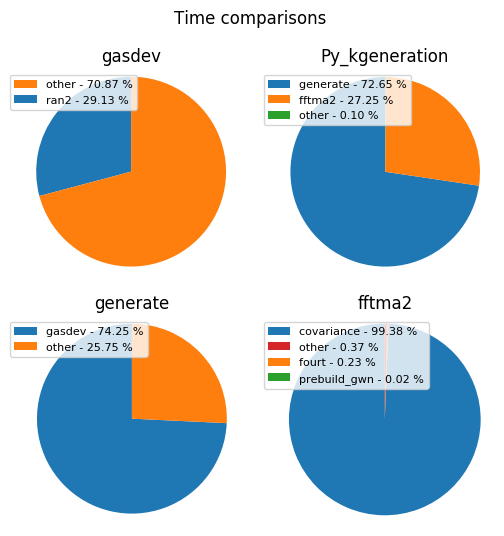

In [35]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [37]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



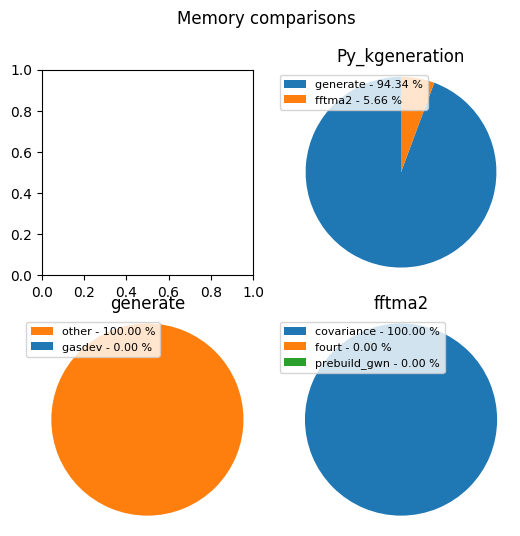

In [36]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## N = 32

### Armado del dataset

In [77]:
df = analyze(['log_32-aa'])
overall_time["32"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["32"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

time                                         memory  \
                      min        max       mean        sum  count    min   
function                                                                   
Py_kgeneration  22.135483  22.135483  22.135483  22.135483      1   53.6   
generate        16.686848  16.686848  16.686848  16.686848      1   48.0   
gasdev           0.000081   0.023022   0.000377  12.362677  32768   -6.2   
fftma2           5.445881   5.445881   5.445881   5.445881      1    5.6   
covariance       5.433282   5.433282   5.433282   5.433282      1    4.9   
ran2             0.000078   0.001366   0.000094   3.885548  41552   -3.0   
cov_value        0.000081   0.000219   0.000094   2.323766  24624   -2.1   
fourt            0.002485   0.003625   0.002885   0.008655      3    0.0   
cgrid            0.001855   0.001855   0.001855   0.001855      1    0.0   
length           0.000294   0.000552   0.000456   0.001369      3    0.0   
build_real       0.000529   0.000529   0.000529   0.000529      1    0.0   
maxfactor        0.000089   0.000093   0.000091   0.000455      5    0.0   
prebuild_gwn     0.000230   0.000230   0.000230   0.000230      1    0.2   
clean_real       0.000172   0.000172   0.000172   0.000172      1    0.0   

                                   cpu                         
                 max median        min         max       mean  
function                                                       
Py_kgeneration  53.6   53.6  24.085573   24.085573  24.085573  
generate        48.0   48.0  13.146080   13.146080  13.146080  
gasdev           3.0    0.0   0.000000  100.100000   0.420267  
fftma2           5.6    5.6  57.504022   57.504022  57.504022  
covariance       4.9    4.9  57.609158   57.609158  57.609158  
ran2             1.7    0.0   0.000000  100.100000   0.071948  
cov_value        0.5    0.0   0.000000  100.100000   0.520748  
fourt            0.5    0.0   0.000000    0.000000   0.000000  
cgrid            0.0    0.0   0.000000    0.000000   0.000000  
length           0.0    0.0   0.000000    0.000000   0.000000  
build_real       0.0    0.0   0.000000    0.000000   0.000000  
maxfactor        0.0    0.0   0.000000    0.000000   0.000000  
prebuild_gwn     0.2    0.2   0.000000    0.000000   0.000000  
clean_real       0.0    0.0   0.000000    0.000000   0.000000

### Comparación de tiempos

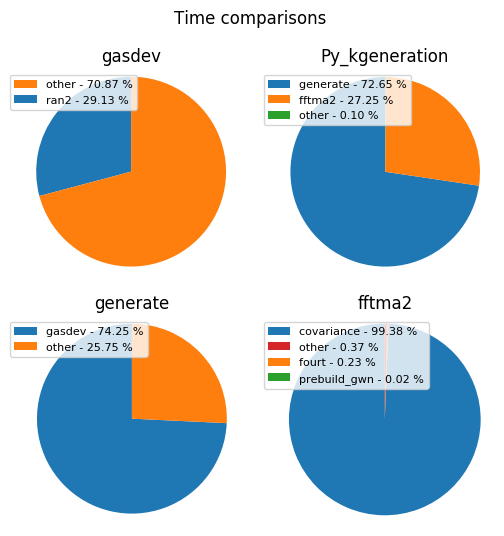

In [38]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [41]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



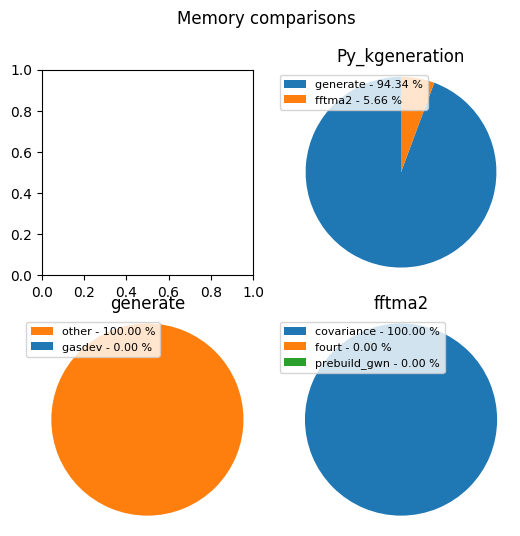

In [39]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## N = 64

### Armado del dataset

In [42]:
df = analyze(['log_64-aa', 'log_64-ab'])
overall_time["64"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["64"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file log_64-aa
Executing file log_64-ab


cpu                       memory                \
                       max       mean        min    max median    min   
function                                                                
Py_kgeneration   32.278779  32.278779  32.278779 -199.3 -199.3 -199.3   
generate         32.749276  32.749276  32.749276 -281.6 -281.6 -281.6   
fftma2           30.472359  30.472359  30.472359   85.3   85.3   85.3   
covariance       30.505800  30.505800  30.505800   80.9   80.9   80.9   
gasdev          100.100000   2.395994   0.000000    8.0    0.0  -61.2   
fourt            25.100000   8.433333   0.100000    2.3    0.4   -0.2   
cov_value       100.100000   0.572549   0.000000    3.0    0.0   -7.1   
ran2            100.100000   0.527507   0.000000    2.7    0.0  -17.8   
build_real        0.000000   0.000000   0.000000    0.0    0.0    0.0   
prebuild_gwn      0.000000   0.000000   0.000000    2.2    2.2    2.2   
clean_real        0.000000   0.000000   0.000000    0.4    0.4    0.4   
cgrid             0.000000   0.000000   0.000000    0.0    0.0    0.0   
length            0.000000   0.000000   0.000000    0.0    0.0    0.0   
maxfactor         0.000000   0.000000   0.000000    0.0    0.0    0.0   

                    time                                                  
                   count         max        mean         min         sum  
function                                                                  
Py_kgeneration       1.0  415.639768  415.639768  415.639768  415.639768  
generate             1.0  329.579564  329.579564  329.579564  329.579564  
fftma2               1.0   86.059132   86.059132   86.059132   86.059132  
covariance           1.0   85.894170   85.894170   85.894170   85.894170  
gasdev          262144.0    0.011277    0.000909    0.000193  242.610944  
fourt                3.0    0.066393    0.050588    0.042309    0.151763  
cov_value       156816.0    0.000575    0.000221    0.000193   34.674709  
ran2            333450.0    0.000691    0.000218    0.000190   74.079918  
build_real           1.0    0.001935    0.001935    0.001935    0.001935  
prebuild_gwn         1.0    0.002618    0.002618    0.002618    0.002618  
clean_real           1.0    0.001551    0.001551    0.001551    0.001551  
cgrid                1.0    0.003504    0.003504    0.003504    0.003504  
length               3.0    0.001141    0.000827    0.000668    0.002481  
maxfactor            4.0    0.000198    0.000195    0.000193    0.000780

### Comparación de tiempos

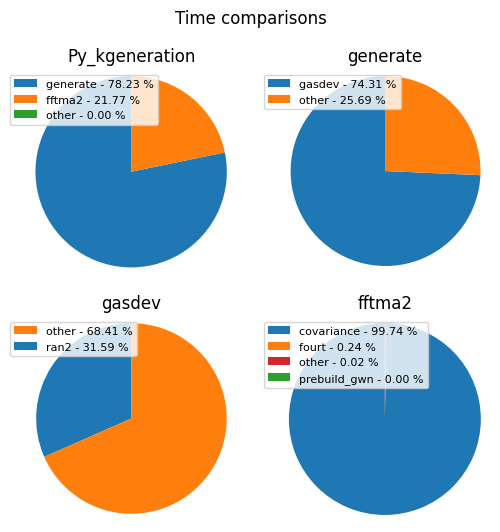

In [70]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [43]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



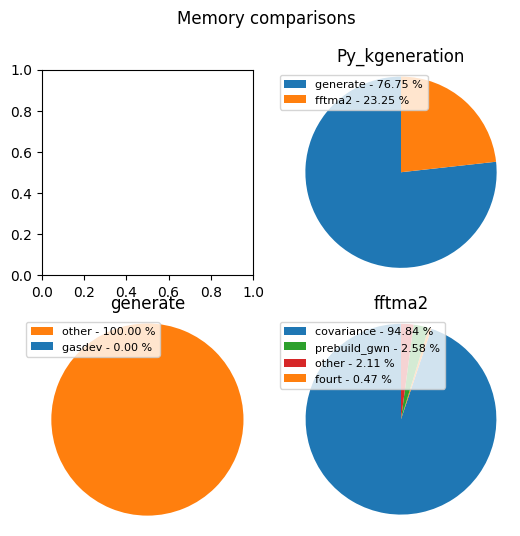

In [44]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## N = 128

### Armado del dataset

In [133]:
df = analyze(['log_128-aa', 'log_128-ab', 'log_128-ac', 'log_128-ad', 'log_128-ae', 'log_128-af', 'log_128-ag', 'log_128-ah', 'log_128-ai', 'log_128-aj', 'log_128-ak'])
overall_time["128"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["128"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file log_128-aa
Executing file log_128-ab
Executing file log_128-ac
Executing file log_128-ad
Executing file log_128-ae
Executing file log_128-af
Executing file log_128-ag
Executing file log_128-ah
Executing file log_128-ai
Executing file log_128-aj
Executing file log_128-ak


memory                      time                            \
                  min   max median          min          max         mean   
function                                                                    
Py_kgeneration  -14.1 -14.1  -14.1  1530.896938  1530.896938  1530.896938   
generate          3.2   3.2    3.2  1198.768697  1198.768697  1198.768697   
fftma2           -2.8  -2.8   -2.8   332.127615   332.127615   332.127615   
covariance      -20.8 -20.8  -20.8   330.818047   330.818047   330.818047   
gasdev          -81.6   7.4    0.0     0.000081     0.016966     0.000428   
fourt             0.5   1.2    0.6     0.336843     0.525952     0.422136   
cov_value        -9.6   2.7    0.0     0.000102     0.000870     0.000124   
ran2            -12.9   4.8    0.0     0.000078     0.002555     0.000107   
build_real       -0.0  -0.0   -0.0     0.021324     0.021324     0.021324   
prebuild_gwn     17.0  17.0   17.0     0.008650     0.008650     0.008650   
clean_real       14.6  14.6   14.6     0.007677     0.007677     0.007677   
cgrid             0.0   0.0    0.0     0.001930     0.001930     0.001930   
length            0.0   0.0    0.0     0.000410     0.000424     0.000418   
maxfactor         0.0   0.0    0.0     0.000117     0.000119     0.000118   

                                              cpu                           
                        sum      count        min         max         mean  
function                                                                    
Py_kgeneration  1530.896938        1.0  14.870018   14.870018  1530.896938  
generate        1198.768697        1.0  12.167592   12.167592  1198.768697  
fftma2           332.127615        1.0  24.482971   24.482971   332.127615  
covariance       330.818047        1.0  24.492196   24.492196   330.818047  
gasdev           891.863931  2097152.0   0.000000  100.100000     0.000428  
fourt              1.266409        3.0  19.065517   26.290476     0.422136  
cov_value        140.268295  1132300.0   0.000000  100.100000     0.000124  
ran2             282.561512  2668394.0   0.000000  100.100000     0.000107  
build_real         0.021324        1.0   0.100000    0.100000     0.021324  
prebuild_gwn       0.008650        1.0   0.100000    0.100000     0.008650  
clean_real         0.007677        1.0   0.000000    0.000000     0.007677  
cgrid              0.001930        1.0   0.000000    0.000000     0.001930  
length             0.001254        3.0   0.000000    0.000000     0.000418  
maxfactor          0.000354        3.0   0.000000    0.000000     0.000118

### Comparación de tiempo

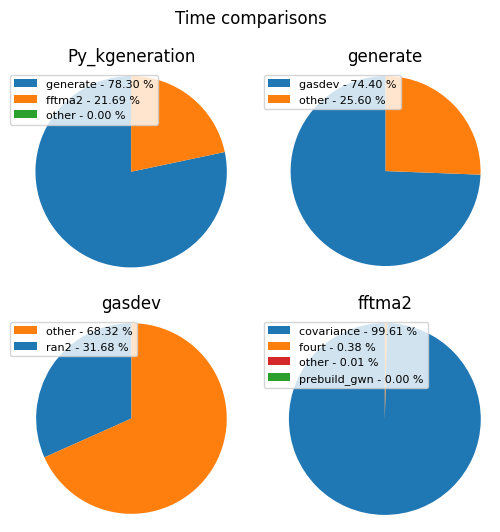

In [134]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [45]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



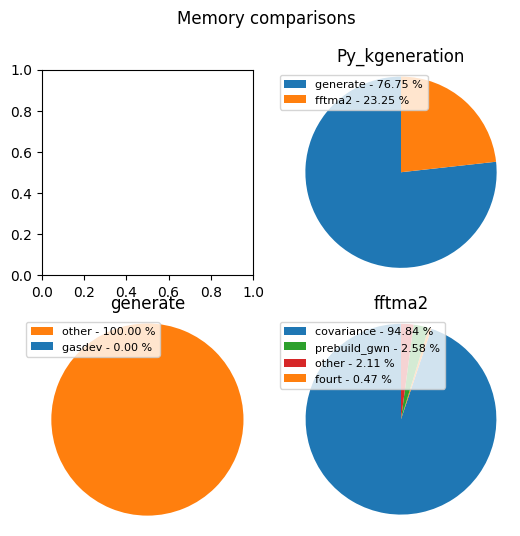

In [46]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## N = 256

### Armado del dataset

In [94]:
df = analyze(['log_256-aa', 'log_256-ab', 'log_256-ac'])
overall_time["256"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["256"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file number 1 out of 10
Executing file number 2 out of 10
Executing file number 3 out of 10
Executing file number 4 out of 10
Executing file number 5 out of 10
Executing file number 6 out of 10
Executing file number 7 out of 10
Executing file number 8 out of 10
Executing file number 9 out of 10
Executing file number 10 out of 10


In [96]:
merge_dfs(dfs)

memory                        time                            \
                   max  median     min       count          max         mean   
function                                                                       
Py_kgeneration  7421.6  7421.6  7421.6         1.0  1226.822575  1226.822575   
generate        6691.7  6691.7  6691.7         1.0   959.799368   959.799368   
fftma2           872.0   872.0   872.0         1.0   267.021516   267.021516   
covariance       870.5   870.5   870.5         1.0   247.512194   247.512194   
gasdev             8.7     0.0   -13.5  16777216.0     0.001358     0.000033   
fourt             11.5    -1.4   -16.2         3.0     8.429829     6.378454   
cov_value          0.7     0.0   -13.9   8855600.0     0.000437     0.000002   
ran2               0.9     0.0    -0.8  21359556.0     0.000381     0.000002   
build_real        -0.2    -0.2    -0.2         1.0     0.151968     0.151968   
prebuild_gwn       6.5     6.5     6.5         1.0     0.108160     0.108160   
clean_real       127.2   127.2   127.2         1.0     0.095267     0.095267   
cgrid              0.0     0.0     0.0         1.0     0.000160     0.000160   
length             0.0     0.0     0.0         3.0     0.000043     0.000034   
maxfactor          0.0     0.0     0.0         5.0     0.000002     0.000002   

                                          
                        min          sum  
function                                  
Py_kgeneration  1226.822575  1226.822575  
generate         959.799368   959.799368  
fftma2           267.021516   267.021516  
covariance       247.512194   247.512194  
gasdev             0.000000   564.182445  
fourt              5.015006    19.135362  
cov_value          0.000001    21.579349  
ran2               0.000000    45.002553  
build_real         0.151968     0.151968  
prebuild_gwn       0.108160     0.108160  
clean_real         0.095267     0.095267  
cgrid              0.000160     0.000160  
length             0.000021     0.000102  
maxfactor          0.000001     0.000008

### Comparación de tiempos

In [ ]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [ ]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

In [ ]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

## Tiempo insumido con distintos N

Se busca mostrar en los siguientes gráficos la relación exponencial que existe entre el tiempo insumido por cada una de las configuraciones de distinto N.

In [94]:
def plot_overall_comparison(info, title, unit):
    fig = plt.figure()
    plt.title(title)
    plt.bar(info.keys(),info.values())
    plt.ylabel(unit)
    plt.xlabel("sizes")
    plt.show()

{'8': 0.544398, '16': 2.908668, '32': 22.135483, '64': 178.629961}


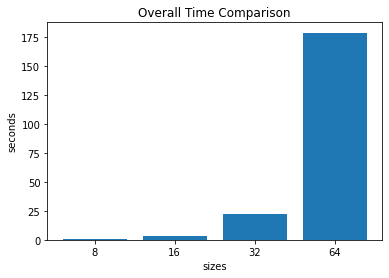

In [95]:
print(overall_time)
plot_overall_comparison(overall_time, "Overall Time Comparison", "seconds")

{'8': 0.2, '16': 11.1, '32': 53.6, '64': 304.2}


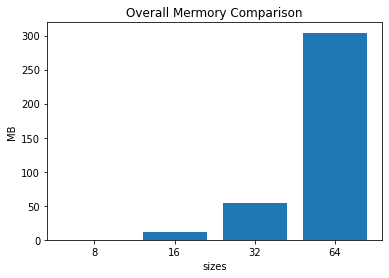

In [97]:
print(overall_memory)
plot_overall_comparison(overall_memory, "Overall Mermory Comparison", "MB")

In [16]:
## CPU analysis

## Identificación de valores usados en las funciones más invocadas

Con los gráficos de las secciones anteriores es posible identificar qué funciones son las que son llamadas una mayor cantidad de veces: `gasdev`, `cov_value` y `ran2`. 

El objetivo de esta sección es analizar con qué valores se llaman a estas funciones para identificar patrones y diferencias.

In [ ]:
functions_repeated = {
    "gasdev":["idum", "idum2", "iy"],
    "cov_value": ["di", "dj", "dk"],
    "ran2": ["idum", "idum2", "iy"],
}

def get_data_from_file(file_name):
    data = {
        "gasdev": {"idum": [], "idum2": [], "iy": []},
        "ran2": {"idum": [], "idum2": [], "iy": []},
        "cov_value": {"di":[], "dj": [], "dk": []}
    }

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            if np.any([f in line for f in functions_repeated.keys()]) and "RESULT = in progress" in line:
                split_line = line.split()
                function_name = get_function_name(split_line[2])
                params = functions_repeated[function_name]
                for p in params:
                    idx_value = split_line.index(p) + 2
                    data[function_name][p].append(float(split_line[idx_value].rsplit(",")[0]))
                #print(split_line)
    return data

def get_repeteated_data(filenames):
    data_total = {}
    for f in filenames:
        data = get_data_from_file(f)
        data_total = {**data_total, **data}
    return data_total

In [248]:
def distribution(data,f, p, plt):
    values = data[f][p]
    if np.isnan(values).all(): return # TODO: Pasa algo raro con gasdev iy en 32
    plt.set_title(f"{p}")
    plt.hist(values, bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
    plt.grid(True)
    plt.set_ylabel("Number of repetitions")
    plt.set_xlabel("value")

def plot_distributions(data, f):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(f"Distribution in params for {f}")
    params = list(data[f].keys())
    for i in range(2):
        for j in range(2):
            if 2*i + j < len(params):
                distribution(data, f,params[2*i + j], axs[i, j])
                
    
    fig.delaxes(axs[1, 1])
    fig.tight_layout(pad=3.0)

In [245]:
def plot_reapeated_data_distribution(data):
    for f in functions_repeated.keys():
        plot_distributions(data,f)

## N = 8

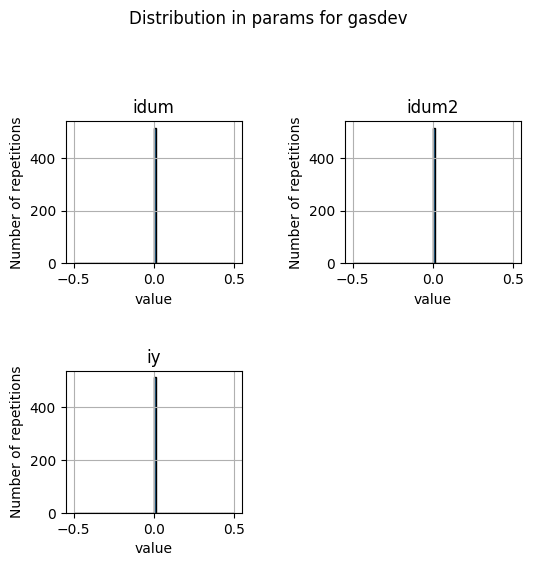

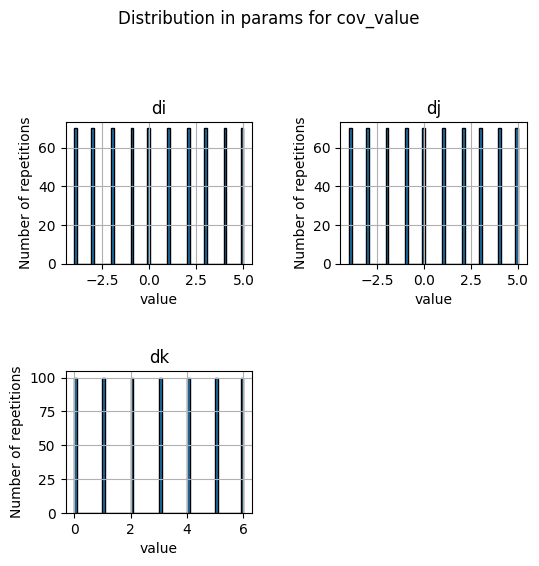

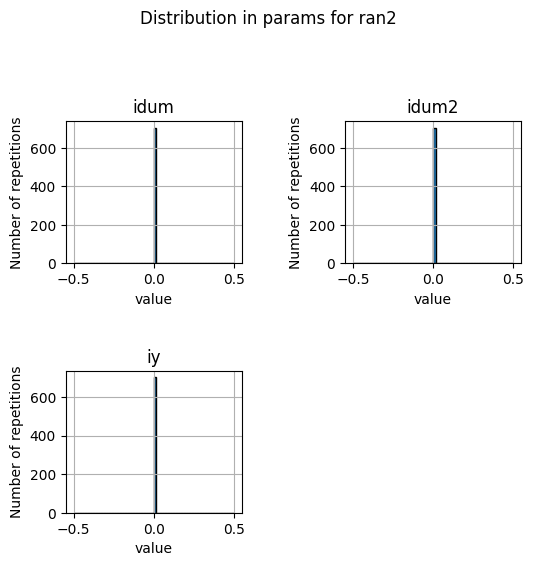

In [234]:
data = get_repeteated_data(['log_8-aa'])
plot_reapeated_data_distribution(data)

## N = 16

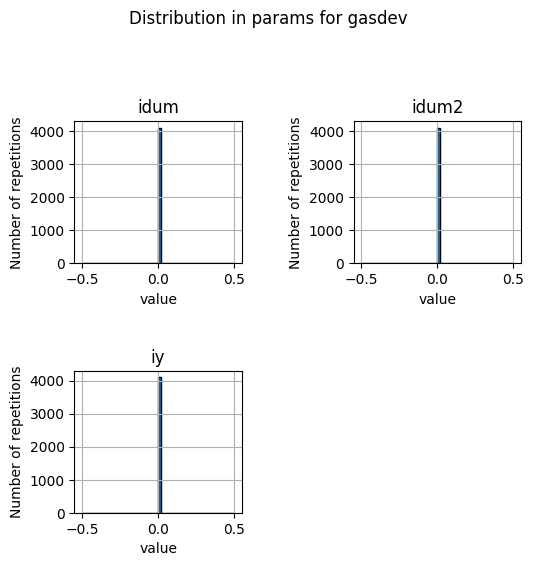

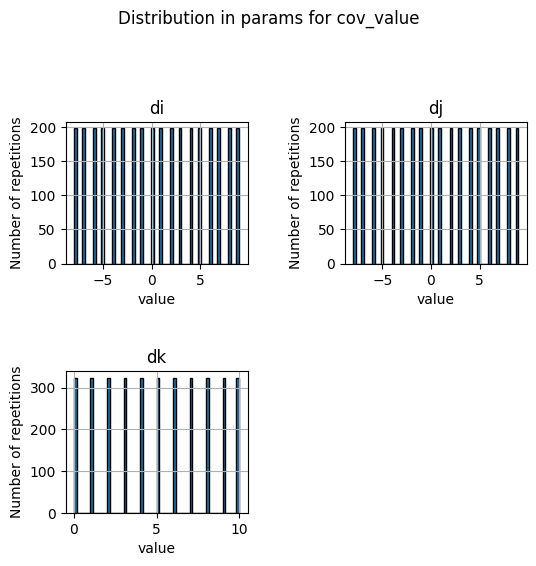

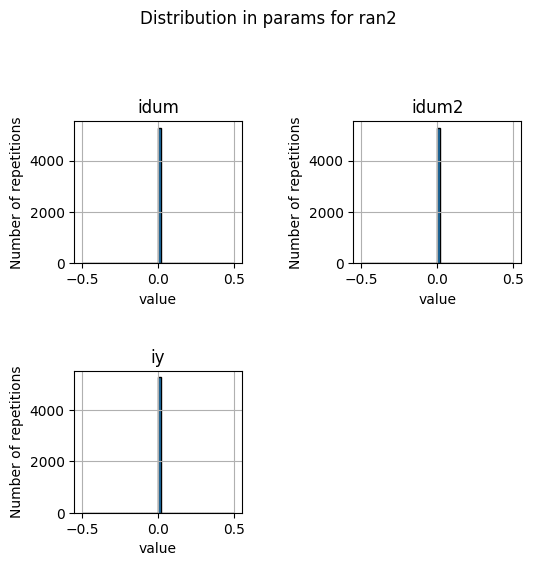

In [235]:
data = get_repeteated_data(['log_16-aa'])
plot_reapeated_data_distribution(data)

## N = 32

gasdev idum
gasdev idum2
gasdev iy
cov_value di
cov_value dj
cov_value dk
ran2 idum
ran2 idum2
ran2 iy


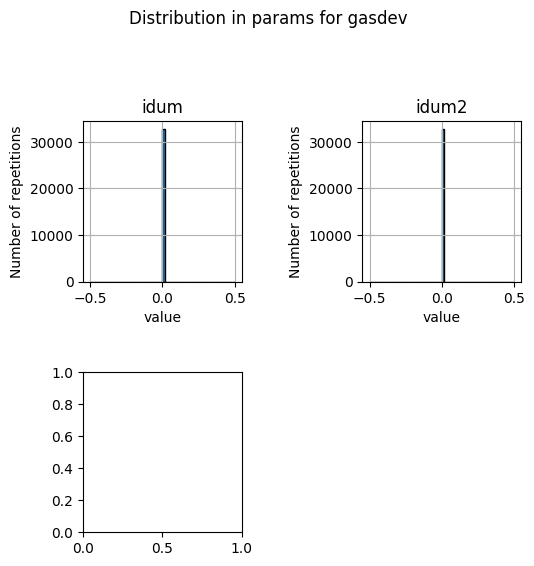

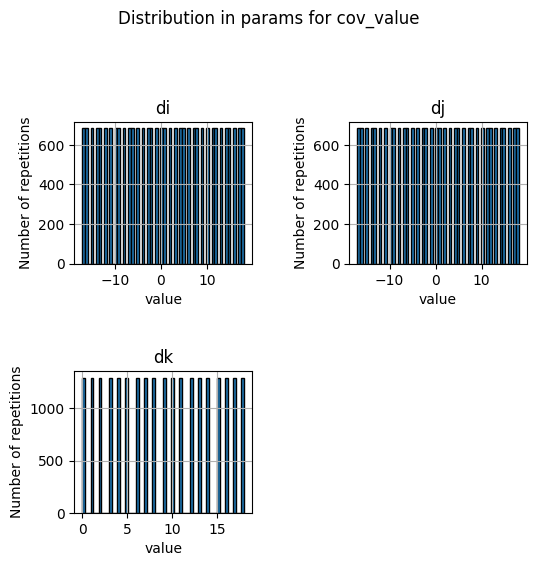

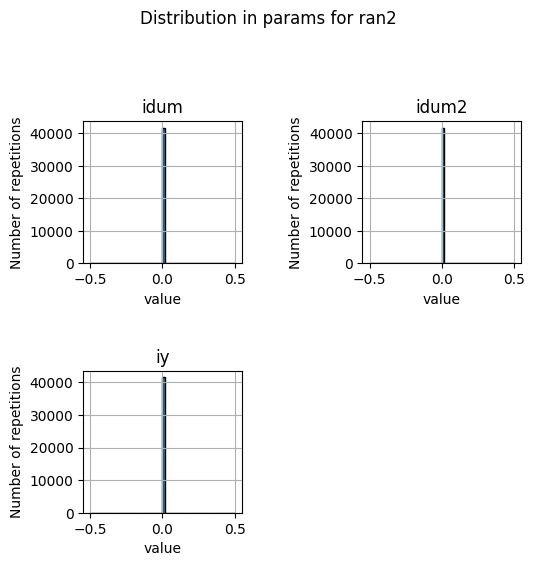

In [246]:
data = get_repeteated_data(['log_32-aa'])
plot_reapeated_data_distribution(data)

## N = 64

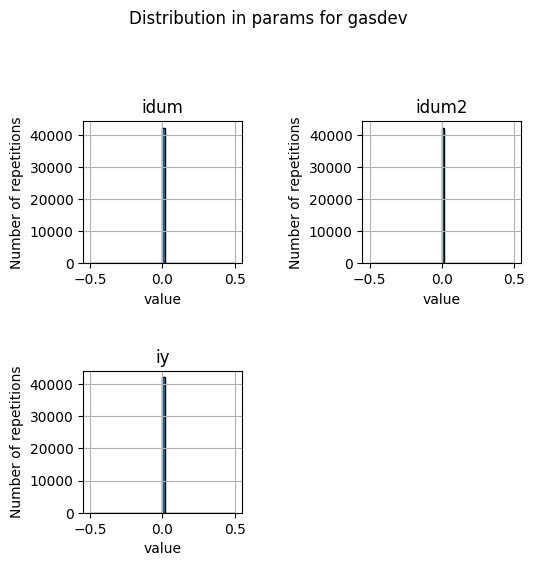

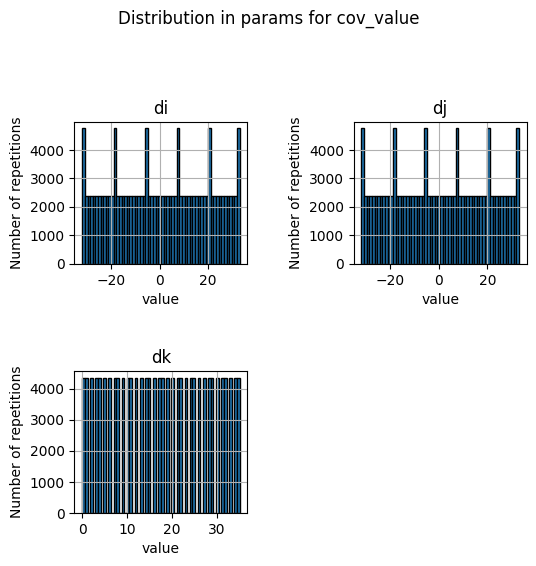

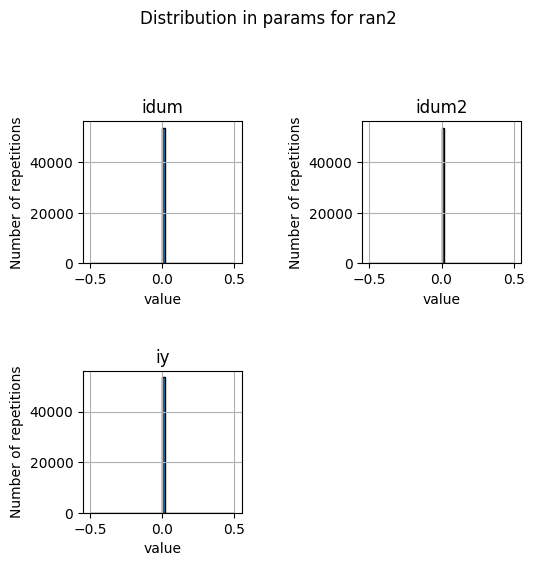

In [249]:
data = get_repeteated_data(['log_64-aa', 'log_64-ab'])
plot_reapeated_data_distribution(data)

# TODO

- Completar analisis de memoria y cpu
- Investigar mas el tema de llamadas a funciones repetidas (gasdev, cov_value, ran2)
- Escribir conclusiones (proximos pasos y cosas que no se consideran importantes)
- Conseguir ayuda en tupac para poder correrlo